In [1]:
import numpy as np
import scipy as sp
from scipy.interpolate import interp1d as spline

from matplotlib import pyplot as plt

%matplotlib inline


In [2]:
# correct for log scale
stim = np.linspace(-.3,1.3,num=1000)

f1,f2 = 3,8
mm = np.log(f1*(1-stim) + f2*(stim))
stim_corrected = (mm-np.amin(mm))/(np.amax(mm)-np.amin(mm))
stim_corrected = stim_corrected*1.1 -.1

stim_spline = sp.interpolate.interp1d(stim,stim_corrected)
# stim_spline = sp.interpolate.interp1d(stim,mm)

og_morph_vec = np.array([0,.25,.5,.75,1])
morph_vec = stim_spline(og_morph_vec)

var_vec = stim_spline(og_morph_vec+.1) - stim_spline(og_morph_vec-.1)
print(morph_vec,var_vec)

[0.31307294 0.52064266 0.67429317 0.79633819 0.89758768] [0.20051695 0.14087321 0.10865253 0.08844931 0.07458963]


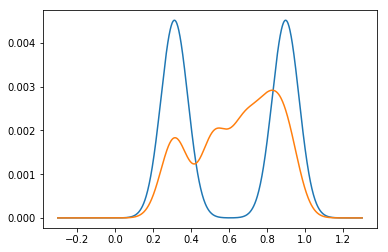

In [51]:

# design input cells - gaussian tuning for different stimulus values
nInputs = 1000
theta = np.linspace(-.3,1.3,num=nInputs)

gaussian = lambda mu,sigma,x: np.exp(-(x-mu)**2/sigma**2)/12

eta = .1
tau = .01

# rare_prior = gaussian(morph_vec[0],var_vec[0],theta)
# rare_prior += gaussian(morph_vec[-1],var_vec[-1],theta)
# rare_prior/=rare_prior.sum()
rare_prior = gaussian(morph_vec[0],.1,theta)
rare_prior += gaussian(morph_vec[-1],.1,theta)
rare_prior/=rare_prior.sum()

# fam_prior = np.zeros(theta.shape)
# for mu,var in zip(morph_vec.tolist(),var_vec.tolist()):
#     fam_prior+=gaussian(mu,var,theta)
# fam_prior /= fam_prior.sum()
fam_prior = np.zeros(theta.shape)
for mu,var in zip(morph_vec.tolist(),var_vec.tolist()):
    fam_prior+=gaussian(mu,.1,theta)
fam_prior /= fam_prior.sum()

def cummulative_prior_spline(prior):
    cum_prior = np.cumsum(prior)
    cum_prior[0],cum_prior[-1] = 0,1
    return spline(cum_prior,theta,kind='linear')


rare_cumprior = cummulative_prior_spline(rare_prior)
fam_cumprior = cummulative_prior_spline(fam_prior)

f,ax = plt.subplots()
ax.plot(theta,rare_prior)
ax.plot(theta,fam_prior)

## single cell model

In [52]:
# single cell model


def single_cell_model(prior_spline):
    w = np.random.rand(nInputs)
    samples =prior_spline(np.random.rand(10000,1))


    for i,s in enumerate(samples.tolist()):
        prob_input = gaussian(theta,.1,s)
    #     draw = np.random.rand(nInputs)
    #     x = 1.*(prob_input>=draw)
    #     y = 1*(np.dot(w,prob_input)>=1)
    #     dw = eta*x*y - tau*w
        dw = eta*prob_input-tau*w
        w+=dw
    #     print(np.linalg.norm(dw,2))
    
    return w

W_rare = single_cell_model(rare_cumprior)
W_fam = single_cell_model(fam_cumprior)
    

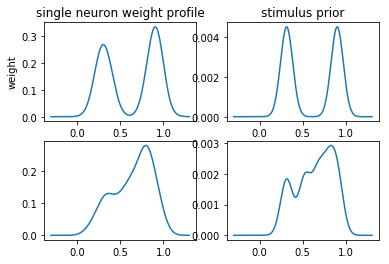

In [53]:
f,ax = plt.subplots(2,2)
ax[0,0].plot(theta,W_rare)
ax[0,0].set_title('single neuron weight profile')
ax[0,0].set_xlabel('input mean tuning')
ax[0,0].set_ylabel('weight')

ax[0,1].plot(theta,rare_prior)
ax[0,1].set_title('stimulus prior')

ax[1,0].plot(theta,W_fam)
ax[1,1].plot(theta,fam_prior)

# 100 Neurons

K winners take all dynamics with Hebbian learning where K is set from empirical data as the proportion of place cells in a particular environment

In [81]:


def network_model(prior_spline, n_neurons=100, wta_k = .4):
    

    W = 2*np.random.rand(nInputs,n_neurons)
    k = int(n_neurons*wta_k)
    
    samples =prior_spline(np.random.rand(10000,1)) 

    for i,s in enumerate(samples.tolist()):
        prob_input =gaussian(theta,.1,s)
        act = np.matmul(W.T,prob_input)
        Y = np.zeros(act.shape)
        
        Y[np.argsort(act)[-1:-k:-1]]=act[np.argsort(act)[-1:-k:-1]] #1
        dw = eta*prob_input[:,np.newaxis]*Y[np.newaxis,:] 
        W+=dw 
        W=np.minimum(W,10)

    YY = np.zeros([stim.shape[0],n_neurons])
    test_theta = np.linspace(-.1,1.1,num=1000)
    for i,s in enumerate(stim_spline(test_theta).tolist()):
        prob_input =gaussian(theta,.2,s) #+ .1*np.random.rand(theta.shape[0])

        act = np.matmul(W.T,prob_input)
        YY[i,np.argsort(act)[-1:-k:-1]]=act[np.argsort(act)[-1:-k:-1]]  #1

    centroid0, centroid1 = YY[test_theta<.1,:].mean(axis=0),YY[test_theta>.9,:].mean(axis=0)
    centroid0/=np.linalg.norm(centroid0.ravel(),ord=2)
    centroid1/=np.linalg.norm(centroid1.ravel(),ord=2)
    print(centroid0.shape,centroid1.shape,YY.shape)
    lar = np.log(np.matmul(YY,centroid0[:,np.newaxis])+ 1E-5)-np.log(np.matmul(YY,centroid1[:,np.newaxis])+ 1E-5)
    
    return W,YY,lar




# Rare Morph 

(100,) (100,) (1000, 100)
0.0 184.44526212600945


Text(0.5, 1.0, 'Log Angle Ratio')

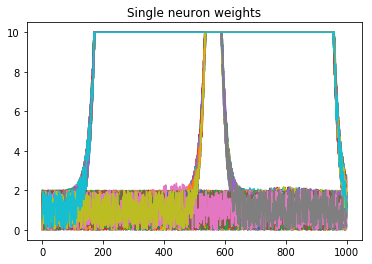

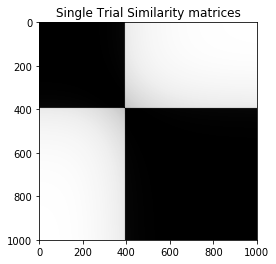

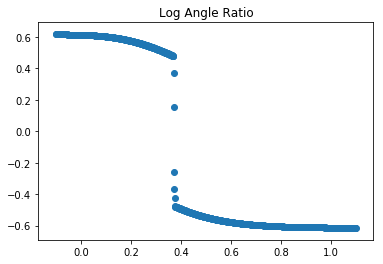

In [82]:
W_rare,YY_rare,lar_rare= network_model(rare_cumprior,wta_k=.4)
print(np.amin(YY_rare),np.amax(YY_rare))
f,ax = plt.subplots()
trsh=ax.plot(W_rare)
ax.set_title('Single neuron weights')

YY_ = YY_rare/np.linalg.norm(YY_rare+1E-5,2,axis=1)[:,np.newaxis]
S = np.matmul(YY_,YY_.T)


f,ax = plt.subplots()
ax.imshow(S,cmap='Greys')
ax.set_title('Single Trial Similarity matrices')

f,ax = plt.subplots()
ax.scatter(np.linspace(-.1,1.1,num=1000),lar_rare)
ax.set_title('Log Angle Ratio')

# Familiar Morph

(100,) (100,) (1000, 100)
0.0 184.44390698753648
(100,) (100,) (1000, 100)
0.0 184.4440380905046
(100,) (100,) (1000, 100)
0.0 184.44406212651205
(100,) (100,) (1000, 100)
0.0 184.44426610498547
(100,) (100,) (1000, 100)
0.0 184.44407447927316


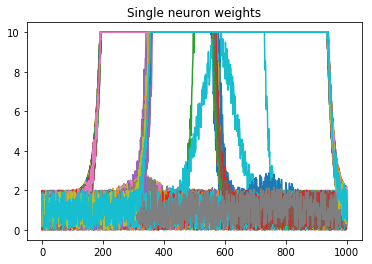

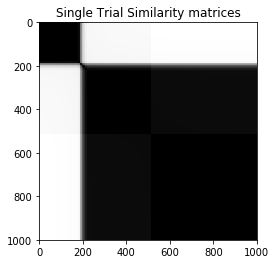

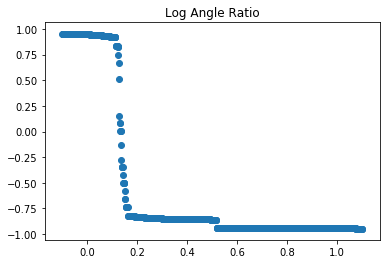

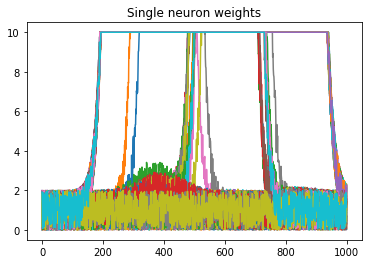

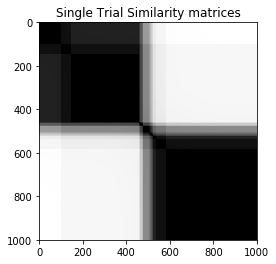

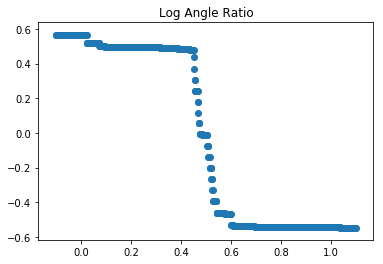

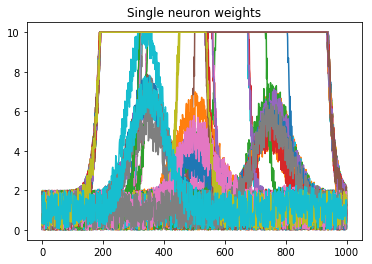

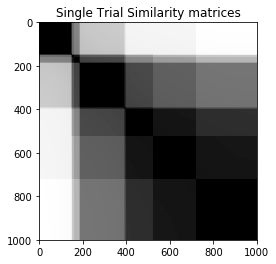

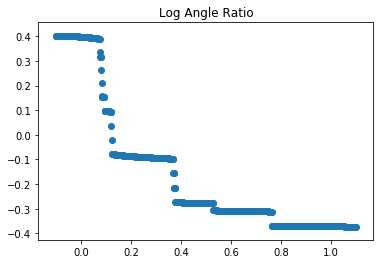

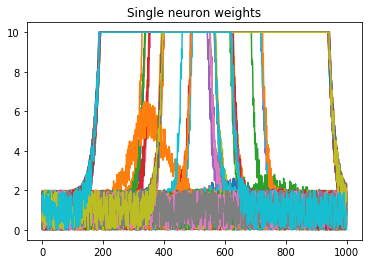

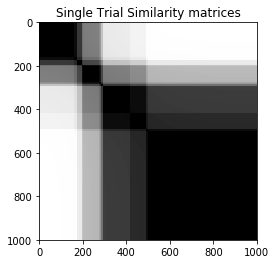

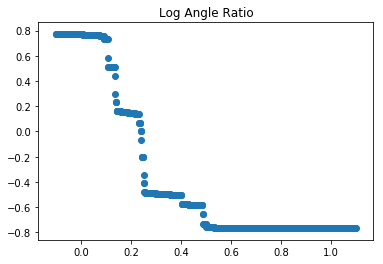

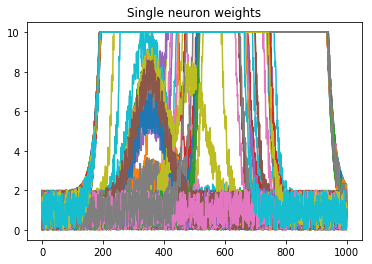

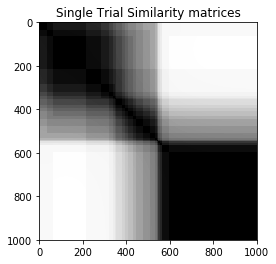

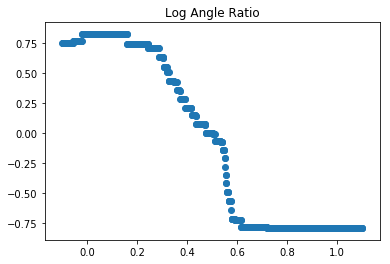

In [86]:

for i in range(5):
    W_fam,YY_fam,lar_fam= network_model(fam_cumprior,wta_k=.4)
    print(np.amin(YY_fam),np.amax(YY_fam))
    f,ax = plt.subplots()
    trsh=ax.plot(W_fam)
    ax.set_title('Single neuron weights')

    YY_ = YY_fam/np.linalg.norm(YY_fam+1E-5,2,axis=1)[:,np.newaxis]
    S = np.matmul(YY_,YY_.T)


    f,ax = plt.subplots()
    ax.imshow(S,cmap='Greys')
    ax.set_title('Single Trial Similarity matrices')


    f,ax = plt.subplots()
    ax.scatter(np.linspace(-.1,1.1,num=1000),lar_fam)
    ax.set_title('Log Angle Ratio')

(1000,) (1000,) (1000, 1000)
0.0 184.44427587252721


Text(0.5, 1.0, 'Log Angle Ratio')

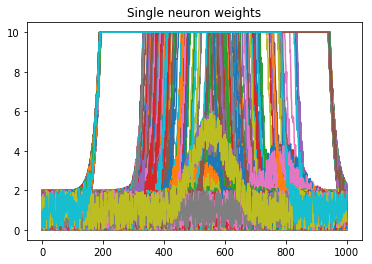

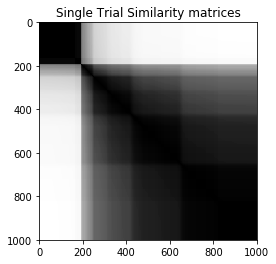

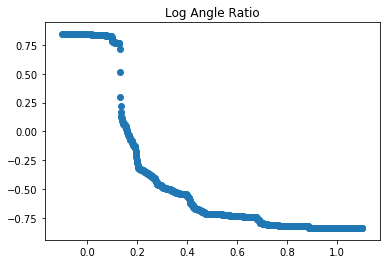

In [87]:
W_fam,YY_fam,lar_fam= network_model(fam_cumprior,wta_k=.4,n_neurons=1000)
print(np.amin(YY_fam),np.amax(YY_fam))
f,ax = plt.subplots()
trsh=ax.plot(W_fam)
ax.set_title('Single neuron weights')

YY_ = YY_fam/np.linalg.norm(YY_fam+1E-5,2,axis=1)[:,np.newaxis]
S = np.matmul(YY_,YY_.T)


f,ax = plt.subplots()
ax.imshow(S,cmap='Greys')
ax.set_title('Single Trial Similarity matrices')


f,ax = plt.subplots()
ax.scatter(np.linspace(-.1,1.1,num=1000),lar_fam)
ax.set_title('Log Angle Ratio')